# CNN for Benign vs Malignant Skin Cancer Classification

## Mount Data From Google Drive

In [0]:
# load the Drive helper and mount
from google.colab import drive

# prompt for authorization
drive.mount('/content/drive')

In [2]:
%cd 'drive/My Drive/scmb'

/content/drive/My Drive/scmb


In [3]:
!ls

data  scmb.ipynb


## Imports

In [4]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim

print('done')

done


## Load Images

In [5]:
# set paths
trn_val_path = 'data/train'
test_path = 'data/test'

# NOTE: can add some more transforms later
# NOTE: Pytorch default backend for images is Pillow -> ToTensor() 
# class automatically converts all images into range [0,1]
transform = transforms.ToTensor()

# load images
trn_val_data = datasets.ImageFolder(root=trn_val_path, transform=transform)
test_data = datasets.ImageFolder(root=test_path, transform=transform)

print('done')

done


### Samplers to Split Images into Training and Validation Sets

In [6]:
# split data into training and validation sets
val_size = 0.25
num_data = len(trn_val_data)
indices = list(range(num_data))
np.random.shuffle(indices)
split = int(np.floor(val_size * num_data))
trn_idx, val_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
trn_sampler = SubsetRandomSampler(trn_idx)
val_sampler = SubsetRandomSampler(val_idx)

print('done')

done


## Dataloaders

In [13]:
# NOTE: data laoders output a 4D tensor -> [batch, channel, height, width]
batch_size = 32

trn_loader = torch.utils.data.DataLoader(trn_val_data, 
                                         batch_size=batch_size, 
                                         sampler=trn_sampler)
val_loader = torch.utils.data.DataLoader(trn_val_data, 
                                         batch_size=batch_size,
                                         sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size)

print(len(trn_loader.sampler), 
      len(val_loader.sampler), 
      len(test_loader.sampler),
      sep='\n') 
print('done')

1978
659
660
done


### Visualise Images From Each Dataloader

Class labels: 
- benign = 0
- malignant = 1

(class labels can be checked with ```dataloader.samples```)

```Matplotlib``` requires matrix in the form ```[height, width, channel]```, while image tensors returned from the dataloader ( ```images[i]```) have shape ```[channels, height, width]```. Therefore, the image tensor must be transposed. 



In [0]:
# helper function to display images
def display_images(dataloader):
    """Displays 20 images and their corresponding labels from a dataloader"""

    # get data from dataloader
    images, labels = next(iter(dataloader))

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))

    # display images
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        ax.imshow(np.transpose(images[idx].numpy(), (1, 2, 0)))
        label = labels[idx].item()
        ax.set_title('{} ({})'.format(label, 'malignant' if label == 1 else 'benign'))
    
    return


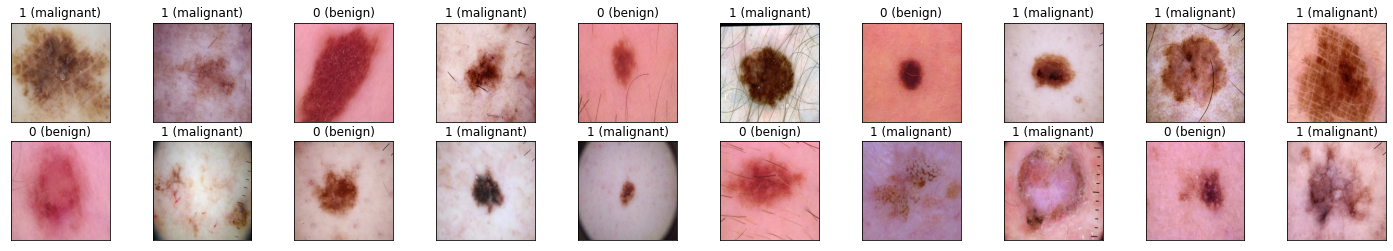

In [14]:
# images from training set
display_images(trn_loader)

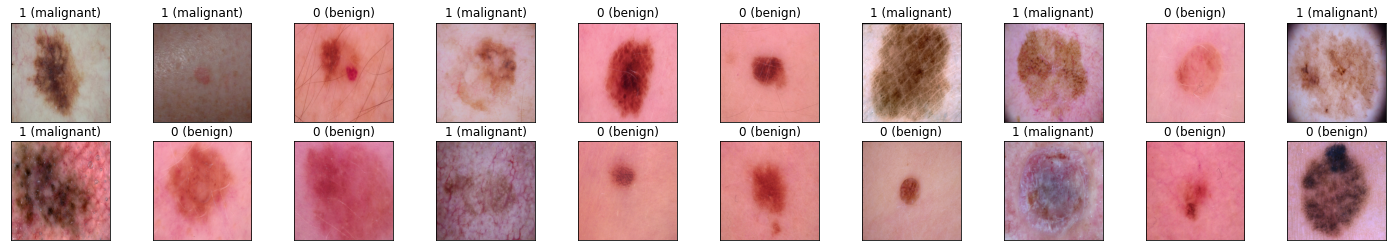

In [15]:
# images from validation set
display_images(val_loader)

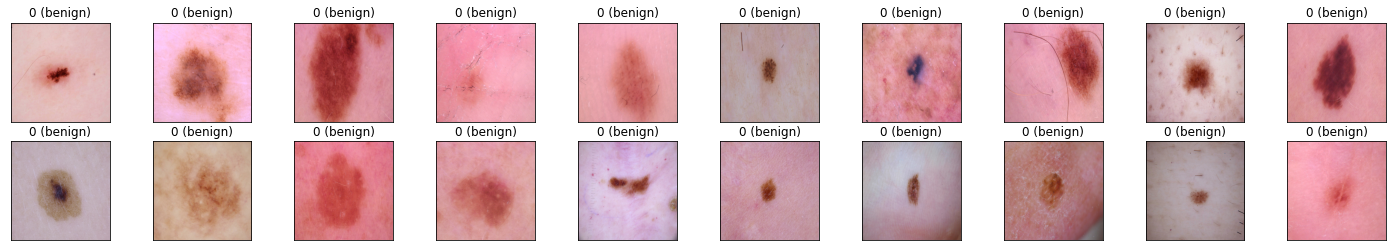

In [16]:
# images from test set
display_images(test_loader)

## Define CNN Architecture

In [17]:
# define model architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # sees 3x224x224 tensor
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # sees 16x112x112 tensor
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # sees 32x56x56 tensor
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # sees 64x28x28 tensor
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)

        self.fc1 = nn.Linear(128*14*14, 800) 
        self.fc2 = nn.Linear(800, 100)
        self.fc3 = nn.Linear(100, 1)

        self.maxpool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):

        # convolutional layers
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x) # output -> 64x28x28
        x = self.relu(self.conv4(x))
        x = self.maxpool(x) # output -> 128x14x14 

        # flatten output of conv layers before passing to fc layers
        x = x.view(x.size(0), 128*14*14) 

        # fully connected layers
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x) # loss fxn applies output layer activation
        return x

print('done')

done


## Set Model, Loss and Optimiser

In [32]:
# https://pytorch.org/docs/master/generated/torch.nn.BCEWithLogitsLoss.html
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN()
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimiser = optim.Adam(model.parameters(), lr=0.0001)

print('model loaded to {}'.format(device))

model loaded to cuda


## Train Model

In [0]:
trn_loss_hx = []
val_loss_hx = []
epochs = 60 

for epoch in range(epochs):

    epoch_trn_loss = 0
    epoch_val_loss = 0
    i = 0

    # training
    model.train()
    for t_images, t_labels in trn_loader:

        if torch.cuda.is_available():
             t_images, t_labels = t_images.to(device), t_labels.to(device)

        # clear gradients
        optimiser.zero_grad()
        # forward pass
        t_output = model.forward(t_images)
        # loss
        t_labels = t_labels.type_as(t_output)
        trn_loss = criterion(t_output.squeeze(), t_labels)
        # backprop
        trn_loss.backward()
        # update parameters
        optimiser.step()

        print(epoch, i)
        i+=1
        epoch_trn_loss += trn_loss.item() * t_images.size(0)

    # validation 
    model.eval()
    for v_images, v_labels in val_loader:

        if torch.cuda.is_available():
            v_images, v_labels = v_images.to(device), v_labels.to(device)

        # forward pass
        v_output = model.forward(v_images)
        # loss
        v_labels = v_labels.type_as(v_output)
        val_loss = criterion(v_output.squeeze(), v_labels)

        epoch_val_loss += val_loss.item() * v_images.size(0)

    # add epoch losses to hx
    trn_loss_hx.append(epoch_trn_loss / len(trn_loader.sampler))
    val_loss_hx.append(epoch_val_loss / len(val_loader.sampler))

    print(epoch)

print('done')

### Plot Training and Validation Losses

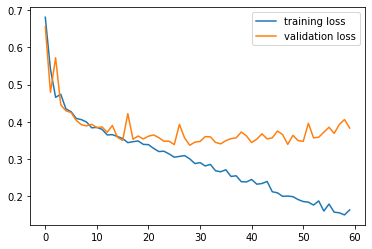

number of parameters: 20248841


In [34]:
plt.plot(trn_loss_hx, label='training loss')
plt.plot(val_loss_hx, label='validation loss')
plt.legend(loc='upper right')
plt.show()

# number of parameters in model - a couple million is ok to have
parameter_count = sum([param.numel() for param in model.parameters()])
print(f'number of parameters: {parameter_count}')

## Evaluate Model Accuracy (F Score)

### Accuracy Function

In [0]:
def accuracy(dataloader, print_results=True):

    # initialise 
    sigmoid = nn.Sigmoid()
    tp, fp, fn = 0, 0, 0

    for images, labels in dataloader:

        # transfer data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # make predictions (need to pass model ouput to sigmoid fxn)
        probabilities = sigmoid(model.forward(images))

        # threshold: <0.5 -> 0; >0.5 -> 1
        preds = (probabilities > 0.5).float()

        # updates
        tp += (labels * preds).sum().float()
        fp += ((1 - labels) * preds).sum().float()
        fn += (labels * (1 - preds)).sum().float()

        print('.', end='')

    # calculate precision, recall, and F score
    e = 1e-8
    P = tp / (tp + fp + e)
    R = tp / (tp + fn + e)
    F = 2 * (P*R)/(P+R+e)

    if print_results:
        print('',
            'precision: {}'.format(P.item()),
            'recall: {}'.format(R.item()),
            'F score: {}'.format(F.item()),
            sep='\n')

    #print('predictions: {}'.format(preds.squeeze()),
    #      'labels: {}'.format(labels.squeeze())

    return P.item(), R.item(), F.item() #, labels, preds


### Test Set Accuracy

In [36]:
# test set accuracy
test_P, test_R, test_F = accuracy(test_loader)


.....................
precision: 0.8129738569259644
recall: 0.8247863054275513
F score: 0.8188375234603882


### Training Set Accuracy

In [37]:
# training set accuracy
trn_P, trn_R, trn_F = accuracy(trn_loader)

..............................................................
precision: 0.46046262979507446
recall: 0.4584721028804779
F score: 0.4594652056694031


### Validation Set Accuracy

In [38]:
# validation set accuracy
val_P, val_R, val_F = accuracy(val_loader)

.....................
precision: 0.4794151186943054
recall: 0.4676309823989868
F score: 0.47344970703125


## Save Results

In [0]:
# NOTE: have not finalised this yet
# maybe write as csv??

import datetime
import json

cur_date = str(datetime.datetime.now().replace(second=0, microsecond=0))

results = {
    'time': str(datetime.datetime.now()),
    'model': str(model),
    'optimiser': 'Adam',
    'learning rate': '0.001',
    'epochs': '60',
    'training loss': str(trn_loss_hx),
    'validation loss': str(val_loss_hx),
    'test loss': ,
    'test accuracy': {
        'precision': str(test_P,
        'recall': str(test_R),
        'F1 score': str(test_F)
    },
    'training accuracy': {
        'precision': str(trn_P,
        'recall': str(trn_R),
        'F1 score': str(trn_F)
    },
    'validation accuracy': {
        'precision': str(val_P),
        'recall': str(val_R),
        'F1 score': str(val_F)
    },
    'notes': 'none'
}

# append to file
